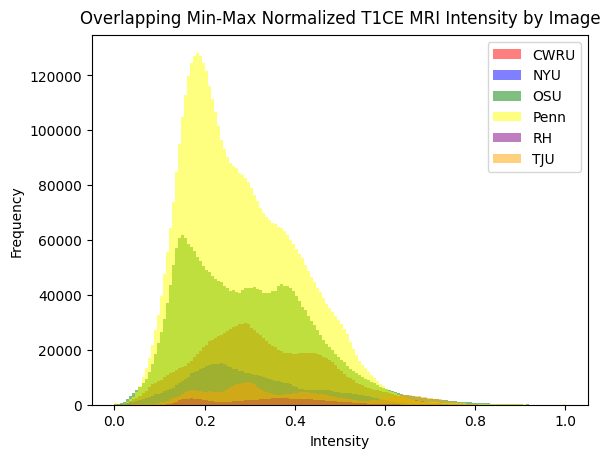

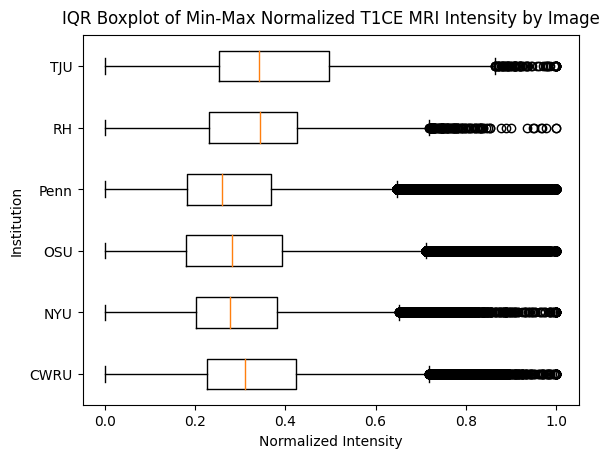

In [5]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import glob
import gzip
import shutil
import os

# Directories for ADC and segmented images for each institution
institutions = {
    'CWRU': ('/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/CWRU/Baseline/',
             '/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/CWRU/Seg/'),
    'NYU': ('/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/NYU/Baseline/',
            '/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/NYU/Seg/'),
    'OSU': ('/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/OSU/Baseline/',
            '/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/OSU/Seg/'),
    'Penn': ('/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/Penn/Baseline/',
             '/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/Penn/Seg/'),
    'RH': ('/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/RH/Baseline/',
           '/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/RH/Seg/'),
    'TJU': ('/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/TJU/Baseline/',
            '/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/TJU/Seg/')
}

# Colors for each institution
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange']

# Bin size
bin_size = 150

all_institutions_normalized_adc_values = []
for index, (institution, paths) in enumerate(institutions.items()):
    baseline_dir, seg_dir = paths
    adc_gz_files = glob.glob(f"{baseline_dir}*t1ce*.gz")
    all_normalized_adc_values = []  # Collect all ADC values here

    for adc_gz_file in adc_gz_files:
        adc_file = adc_gz_file[:-3]  # Expected .nii file name after extraction

        if not os.path.exists(adc_file):
            with gzip.open(adc_gz_file, 'rb') as f_in:
                with open(adc_file, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)

        file_name_parts = os.path.basename(adc_file).split('_')
        segmented_file_name = f"{file_name_parts[0]}_{file_name_parts[1]}_LPS_rSRI_segmF.nii"
        segmented_file = os.path.join(seg_dir, segmented_file_name)

        if not os.path.exists(segmented_file):
            segmented_gz_file = segmented_file + '.gz'
            if os.path.exists(segmented_gz_file):
                with gzip.open(segmented_gz_file, 'rb') as f_in:
                    with open(segmented_file, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)

        try:
            adc_img = nib.load(adc_file)
            segmented_img = nib.load(segmented_file)
            adc_data = adc_img.get_fdata()
            segmented_data = segmented_img.get_fdata()
            edema_adc_values = adc_data[segmented_data == 2]
            min_adc = np.min(edema_adc_values)
            max_adc = np.max(edema_adc_values)
            normalized_adc_values = (edema_adc_values - min_adc) / (max_adc - min_adc)
            all_normalized_adc_values.extend(normalized_adc_values)

        except Exception as e:
            print(f"Error reading file {adc_file}: {e}")
            continue

    # Append the combined normalized ADC values of all files for the current institution
    if all_normalized_adc_values:  # Check if the list is not empty
        all_institutions_normalized_adc_values.append(all_normalized_adc_values)


    # Filter out values above 1200
    #all_normalized_adc_values = [x for x in all_normalized_adc_values if x <= 2000]
    # Plot the histogram for each institution after collecting all ADC values
    plt.hist(all_normalized_adc_values, bins=bin_size, alpha=0.5, color=colors[index], label=institution)

plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.title('Overlapping Min-Max Normalized T1CE MRI Intensity by Image', y=1.01)

plt.show()

plt.figure()  # Create a new figure for the boxplot
# Plot the box plot for each institution's normalized ADC values
plt.boxplot(all_institutions_normalized_adc_values, labels=institutions.keys(), vert=0)
# Add labels to the box plot
plt.ylabel('Institution')
plt.xlabel('Normalized Intensity')
plt.title('IQR Boxplot of Min-Max Normalized T1CE MRI Intensity by Image', y=1.01)
# Show the box plot
plt.show()
